In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from icecream import ic
import neuroml as nml
import neuroml.writers as writers
from pyneuroml.lems import LEMSSimulation
from pyneuroml import pynml
import os
from scipy import signal as sg

# This Python script is purely meant for plotting the important figures in my report, mostly the explanatory pictures.

Every good paper or BEP report needs some good supporting figures that explain the methods, or workings of underlying mechanisms, i.e. figures that you don't necessarily get from the results alone. Those (to me trivial) plots are what this file is for. In an ideal case, this script might even help an unknowing reader understand the matter that I'm working with better.

The plots that I'll be producing are the following:
- Behaviour of an IO cell
- Activation Variables and how they produce IO behaviour
- Channel behaviour -> incl. time constants (voltage dependent) and steady-state values
- Q10-behaviour plot?
- First trace & end trace clusters of interest

### Behaviour of an IO cell

One of the big reasons as to why we're investigating the Inferior Olive, is its characteristic behaviour; the calcium dynamics play a huge role, and this makes the membrane potential traces look very different. Not only when given an input, but sometimes also in rest.

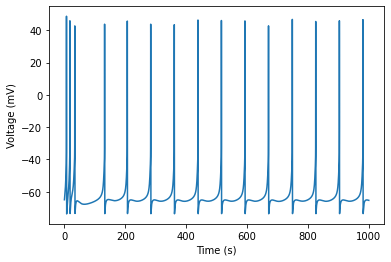

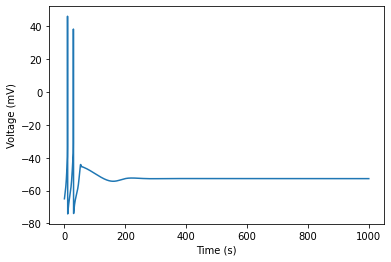

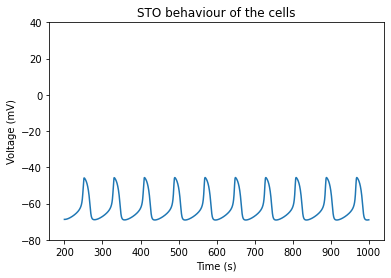

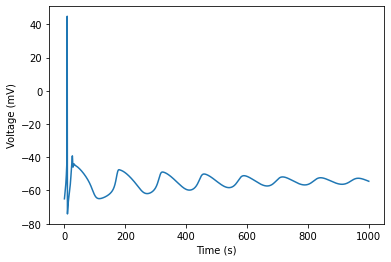

ic| results_dict: {}


pyNeuroML >>> Written LEMS Simulation Test_spike to file: LEMS_Test_spike.xml
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_spike.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Test_spike.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running; plotting True


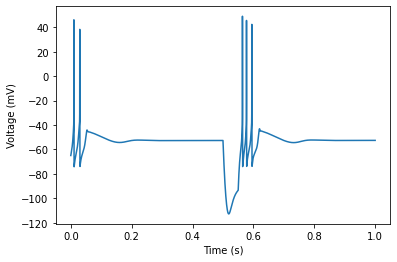

In [50]:
datset = pd.read_csv("C11A_0_20to40_step0.1_v_nopulse.csv",index_col=0)
datset_T = pd.DataFrame.transpose(datset)
time = np.array(datset_T.index)
volt = np.array(datset_T['20.0degC'])
time,volt = [float(ss)*1000 for ss in time],[float(tt)*1000 for tt in volt]
plt.figure()
plt.plot(time,volt)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.show()

datset = pd.read_csv("C23_0_20to40_step0.1_v_nopulse.csv",index_col=0)
datset_T = pd.DataFrame.transpose(datset)
time = np.array(datset_T.index)
volt = np.array(datset_T['20.0degC'])
time,volt = [float(ss)*1000 for ss in time],[float(tt)*1000 for tt in volt]
plt.figure()
plt.plot(time,volt)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.show()

datset = pd.read_csv("C31_0_20to40_step0.1_v_nopulse.csv",index_col=0)
datset_T = pd.DataFrame.transpose(datset)
time = np.array(datset_T.index)
volt = np.array(datset_T['37.0degC'])
time,volt = [float(ss)*1000 for ss in time[2000:]],[float(tt)*1000 for tt in volt[2000:]]
plt.figure()
plt.plot(time,volt)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.ylim([-80,40])
plt.title("STO behaviour of the cells")
plt.show()

datset = pd.read_csv("C51B_0_20to40_step0.1_v_nopulse.csv",index_col=0)
datset_T = pd.DataFrame.transpose(datset)
time = np.array(datset_T.index)
volt = np.array(datset_T['20.0degC'])
time,volt = [float(ss)*1000 for ss in time],[float(tt)*1000 for tt in volt]
plt.figure()
plt.plot(time,volt)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.show()

output_dict = {}
results_dict = {}
ic(results_dict)
path=os.getcwd()
nml_doc = nml.NeuroMLDocument(id="net")
incl = nml.IncludeType(href="C23_scaled_exp_resample_5_relabel.cell.nml")
nml_doc.includes.append(incl)
net = nml.Network(id="net", type="networkWithTemperature", temperature="20degC")
nml_doc.networks.append(net)
pop = nml.Population(id="pop", component="C23", type="populationList", size="1")
net.populations.append(pop)
loc = nml.Location(x="0", y="0", z="0")
inst = nml.Instance(id="0", location=loc)
pop.instances.append(inst)

pg = nml.PulseGenerator(id="iclamp0", delay="0ms", duration="1000ms", amplitude="-1nA")
#nml_doc.pulse_generators.append(pg)
pg2 = nml.PulseGenerator(id="iclamp2", delay="500ms", duration="50ms", amplitude="-1nA")
nml_doc.pulse_generators.append(pg2)
il = nml.InputList(id="clamps", component=pg.id, populations="pop")
ip = nml.Input(id="0", target="../pop/0/C23", segmentId="5", destination="synapses")
#il.input.append(ip)
#net.input_lists.append(il)

il2 = nml.InputList(id="clamps", component=pg2.id, populations="pop")
ip2 = nml.Input(id="1", target="../pop/0/C23", segmentId="0", destination="synapses")
il2.input.append(ip2)
net.input_lists.append(il2)
nml_file = "nml_C23.net.nml"
writers.NeuroMLWriter.write(nml_doc, nml_file)
ls = LEMSSimulation("Test_spike", 1000, 0.1, target = 'net')
ls.include_neuroml2_file("nml_C23.net.nml")
ls.create_display('display0', "Spiking pattern", "-90", "50")
of0 = 'Volts_file'
ls.create_output_file(of0, "Test_spike.v.dat")
ls.add_line_to_display('display0','v','pop/0/C23/5/v')
ls.add_column_to_output_file('Volts_file','v','pop/0/C23/5/v')
ls.save_to_file(file_name="LEMS_Test_spike.xml")
lems_file = path+'/LEMS_Test_spike.xml'

fin = open(lems_file, 'rt')
data = fin.read()
data = data.replace('ExpTime.nml', '../channels/ExpTime.nml')    # patch up for wrong path generated in network script
fin.close()
fin = open(lems_file, 'wt')
fin.write(data)
fin.close()

out_dir,rel_filename = os.path.split(lems_file)

results_dict = pynml.run_lems_with_jneuroml_neuron(rel_filename, verbose=False, nogui=True, load_saved_data=True, exec_in_dir=out_dir,max_memory='400M')
#results_dict = eden_tools.runEden( rel_filename, verbose=False )

results_dict['pop/0/C23/5/v.20degC'] = results_dict.pop('pop/0/C23/5/v')
output_dict.update(results_dict)

if 't' in output_dict:
    t = output_dict.pop('t')

plt.figure()
plt.plot(t,[v*1000 for v in output_dict.pop('pop/0/C23/5/v.20degC')])
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.title("Spiking behaviour of cells")
plt.show()

ic| cell: 'C10'
ic| cell: 'C11A'
ic| cell: 'C21B'
ic| cell: 'C23'
ic| cell: 'C31'
ic| cell: 'C51A'
ic| cell: 'C51B'


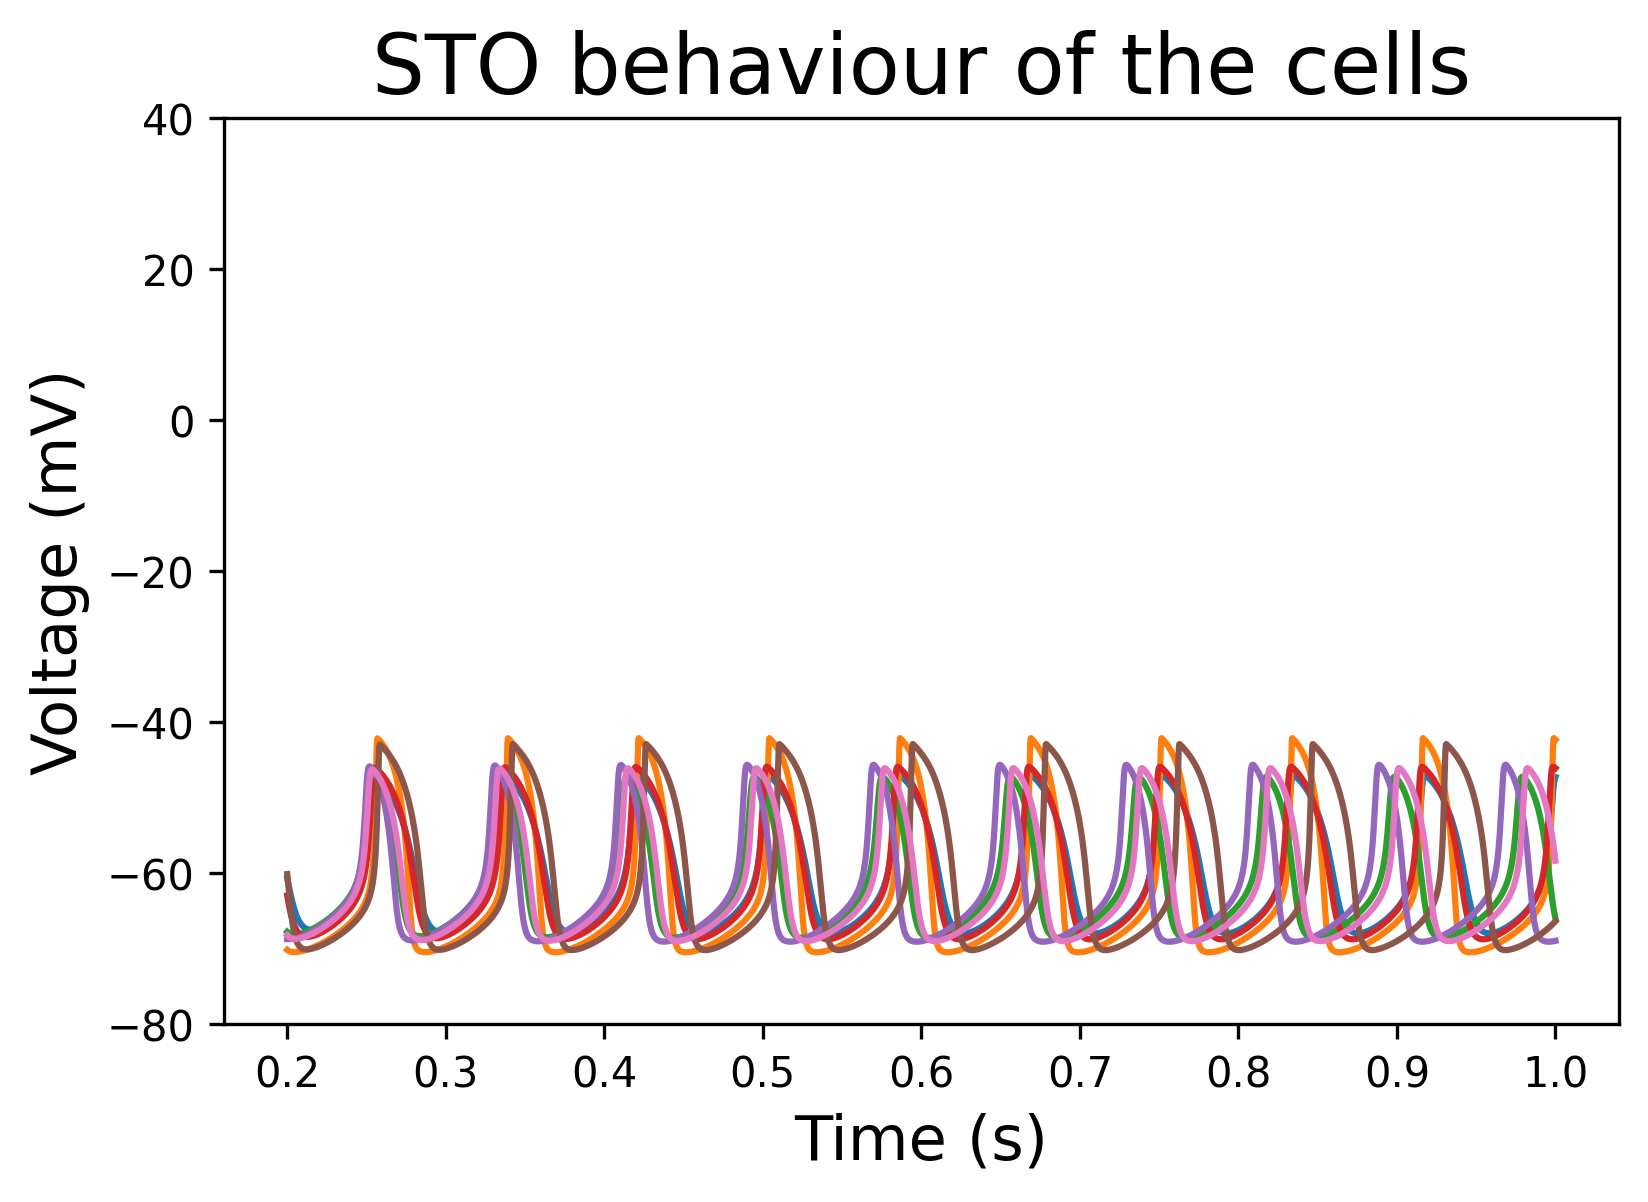

In [20]:
cells = ["C10", "C11A", "C21B", "C23", "C31", "C51A", "C51B"]

fig = plt.figure()
ax = plt.axes()

for cell in cells:
    ic(cell)
    datset = pd.read_csv(f"{cell}_0_20to40_step0.1_v_nopulse.csv",index_col=0)
    datset_T = pd.DataFrame.transpose(datset)
    time = np.array(datset_T.index)
    volt = np.array(datset_T['37.0degC'])
    time,volt = [float(ss) for ss in time[2000:]],[float(tt)*1000 for tt in volt[2000:]]
    ax.plot(time,volt)
fig.set_dpi(300.0)
ax.set_xlabel('Time (s)', fontsize=15)
ax.set_ylabel('Voltage (mV)', fontsize=15)
ax.set_ylim([-80,40])
ax.set_title("STO behaviour of the cells", fontsize=20)
plt.show()

ic| cell: 'C10'


pyNeuroML >>> Written LEMS Simulation Test_spike to file: LEMS_Test_spike.xml


ic| cell: 'C11A'


pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_spike.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Test_spike.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running; plotting True
pyNeuroML >>> Written LEMS Simulation Test_spike to file: LEMS_Test_spike.xml


ic| cell: 'C21B'


pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_spike.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Test_spike.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running; plotting True
pyNeuroML >>> Written LEMS Simulation Test_spike to file: LEMS_Test_spike.xml


ic| cell: 'C23'


pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_spike.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Test_spike.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running; plotting True
pyNeuroML >>> Written LEMS Simulation Test_spike to file: LEMS_Test_spike.xml


ic| cell: 'C31'


pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_spike.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Test_spike.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running; plotting True
pyNeuroML >>> Written LEMS Simulation Test_spike to file: LEMS_Test_spike.xml


ic| cell: 'C51A'


pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_spike.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Test_spike.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running; plotting True
pyNeuroML >>> Written LEMS Simulation Test_spike to file: LEMS_Test_spike.xml


ic| cell: 'C51B'


pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_spike.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Test_spike.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running; plotting True
pyNeuroML >>> Written LEMS Simulation Test_spike to file: LEMS_Test_spike.xml
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_spike.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Test_spike.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running; plotting True


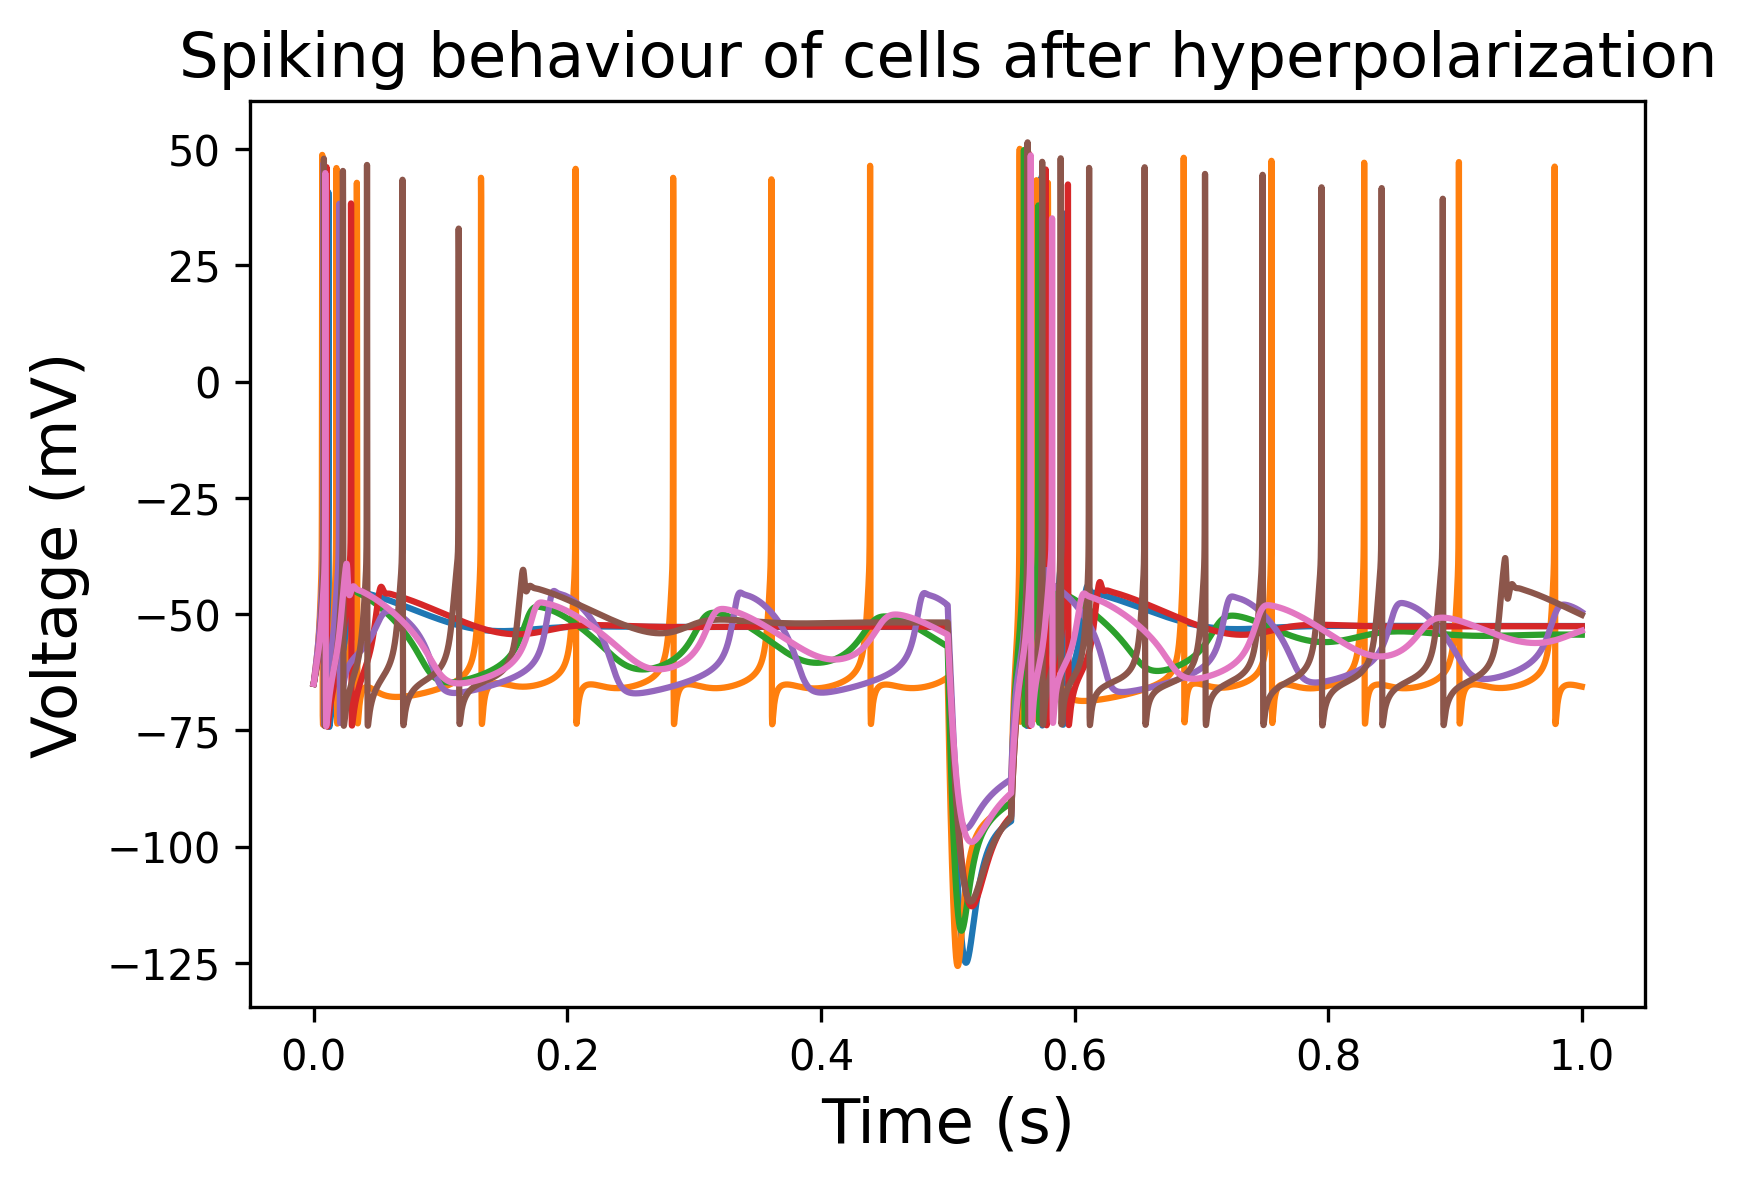

In [24]:
output_dict = {}
results_dict = {}
path=os.getcwd()
fig = plt.figure()
ax = plt.axes()
for cell in cells:
    ic(cell)
    nml_doc = nml.NeuroMLDocument(id="net")
    incl = nml.IncludeType(href=f"{cell}_scaled_exp_resample_5_relabel.cell.nml")
    nml_doc.includes.append(incl)
    net = nml.Network(id="net", type="networkWithTemperature", temperature="20degC")
    nml_doc.networks.append(net)
    pop = nml.Population(id="pop", component=cell, type="populationList", size="1")
    net.populations.append(pop)
    loc = nml.Location(x="0", y="0", z="0")
    inst = nml.Instance(id="0", location=loc)
    pop.instances.append(inst)

    pg = nml.PulseGenerator(id="iclamp0", delay="0ms", duration="1000ms", amplitude="-1nA")
    #nml_doc.pulse_generators.append(pg)
    pg2 = nml.PulseGenerator(id="iclamp2", delay="500ms", duration="50ms", amplitude="-1nA")
    nml_doc.pulse_generators.append(pg2)
    il = nml.InputList(id="clamps", component=pg.id, populations="pop")
    ip = nml.Input(id="0", target=f"../pop/0/{cell}", segmentId="5", destination="synapses")
    #il.input.append(ip)
    #net.input_lists.append(il)

    il2 = nml.InputList(id="clamps", component=pg2.id, populations="pop")
    ip2 = nml.Input(id="1", target=f"../pop/0/{cell}", segmentId="0", destination="synapses")
    il2.input.append(ip2)
    net.input_lists.append(il2)
    nml_file = f"nml_{cell}.net.nml"
    writers.NeuroMLWriter.write(nml_doc, nml_file)
    ls = LEMSSimulation("Test_spike", 1000, 0.1, target = 'net')
    ls.include_neuroml2_file(f"nml_{cell}.net.nml")
    ls.create_display('display0', "Spiking pattern", "-90", "50")
    of0 = 'Volts_file'
    ls.create_output_file(of0, "Test_spike.v.dat")
    ls.add_line_to_display('display0','v',f'pop/0/{cell}/0/v')
    ls.add_column_to_output_file('Volts_file','v',f'pop/0/{cell}/0/v')
    ls.save_to_file(file_name="LEMS_Test_spike.xml")
    lems_file = path+'/LEMS_Test_spike.xml'

    fin = open(lems_file, 'rt')
    data = fin.read()
    data = data.replace('ExpTime.nml', '../channels/ExpTime.nml')    # patch up for wrong path generated in network script
    fin.close()
    fin = open(lems_file, 'wt')
    fin.write(data)
    fin.close()

    out_dir,rel_filename = os.path.split(lems_file)

    results_dict = pynml.run_lems_with_jneuroml_neuron(rel_filename, verbose=False, nogui=True, load_saved_data=True, exec_in_dir=out_dir,max_memory='400M')
    #results_dict = eden_tools.runEden( rel_filename, verbose=False )

    results_dict[f'pop/0/{cell}/0/v.20degC'] = results_dict.pop(f'pop/0/{cell}/0/v')
    output_dict.update(results_dict)

    if 't' in output_dict:
        t = output_dict.pop('t')

    ax.plot(t,[v*1000 for v in output_dict.pop(f'pop/0/{cell}/0/v.20degC')])
fig.set_dpi(300.0)
ax.set_xlabel('Time (s)', fontsize=15)
ax.set_ylabel('Voltage (mV)', fontsize=15)
ax.set_title("Spiking behaviour of cells after hyperpolarization", fontsize=15)
plt.show()

### Activation Variables

The behaviour of the IO cell is generated by gating variables indicating what fraction of the ion gates are open. Which part of the behaviour is governed by which activation variable?

ic| cell: 'C11A', dend: 6


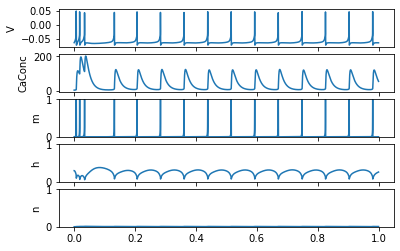

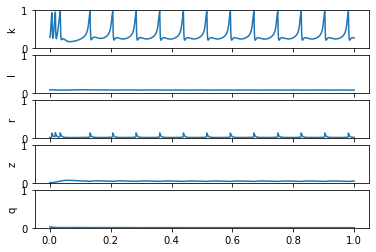


---------------------------------------------------------



ic| cell: 'C23', dend: 5


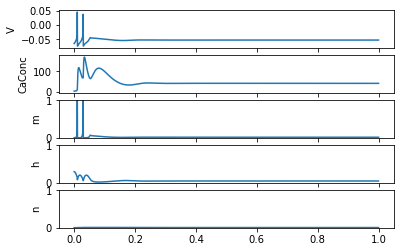

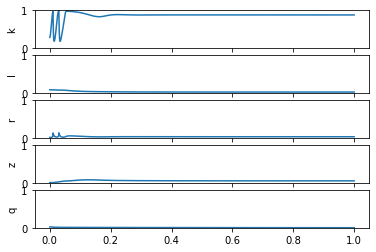


---------------------------------------------------------



ic| cell: 'C31', dend: 5


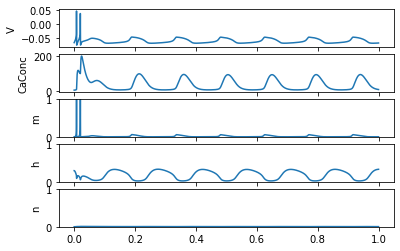

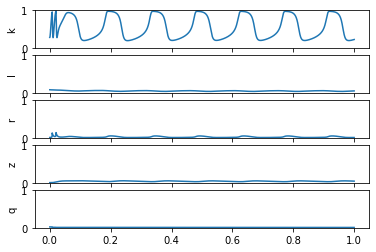


---------------------------------------------------------



ic| cell: 'C51B', dend: 5


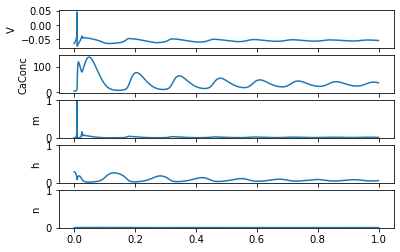

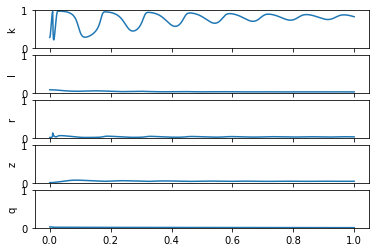


---------------------------------------------------------



In [72]:
#AVs = ['m','h','n','k','l','r','z','q']
cells = ['C11A','C23','C31','C51B']
#cells = ['C31']

for cell in cells:
    dend = 6 if cell == 'C10' or cell == 'C11A' else 5
    ic(cell,dend)
    plt.subplot(5,1,1)
    yaxis = pd.DataFrame.transpose(pd.read_csv(f"{cell}_0_20to40_step0.1_v_nopulse.csv",index_col=0))['20.0degC']
    plt.plot(t,yaxis)
    plt.ylabel('V')
    
    plt.subplot(5,1,2)
    yaxis = pd.DataFrame.transpose(pd.read_csv(f"{cell}_{dend}_20to40_step0.1_caConc_nopulse.csv",index_col=0))['20.0degC']
    plt.plot(t,yaxis)
    plt.ylabel('CaConc')
    
    plt.subplot(5,1,3)
    yaxis = pd.DataFrame.transpose(pd.read_csv(f"{cell}_0_20to40_step0.1_m_nopulse.csv",index_col=0))['20.0degC']
    plt.plot(t,yaxis)
    plt.ylim([0,1])
    plt.ylabel('m')
    
    plt.subplot(5,1,4)
    yaxis = pd.DataFrame.transpose(pd.read_csv(f"{cell}_0_20to40_step0.1_h_nopulse.csv",index_col=0))['20.0degC']
    plt.plot(t,yaxis)
    plt.ylim([0,1])
    plt.ylabel('h')
    
    plt.subplot(5,1,5)
    yaxis = pd.DataFrame.transpose(pd.read_csv(f"{cell}_0_20to40_step0.1_n_nopulse.csv",index_col=0))['20.0degC']
    plt.plot(t,yaxis)
    plt.ylim([0,1])
    plt.ylabel('n')
    plt.show()
    
    plt.subplot(5,1,1)
    yaxis = pd.DataFrame.transpose(pd.read_csv(f"{cell}_0_20to40_step0.1_k_nopulse.csv",index_col=0))['20.0degC']
    plt.plot(t,yaxis)
    plt.ylim([0,1])
    plt.ylabel('k')
    
    plt.subplot(5,1,2)
    yaxis = pd.DataFrame.transpose(pd.read_csv(f"{cell}_0_20to40_step0.1_l_nopulse.csv",index_col=0))['20.0degC']
    plt.plot(t,yaxis)
    plt.ylim([0,1])
    plt.ylabel('l')
    
    plt.subplot(5,1,3)
    yaxis = pd.DataFrame.transpose(pd.read_csv(f"{cell}_{dend}_20to40_step0.1_r_nopulse.csv",index_col=0))['20.0degC']
    plt.plot(t,yaxis)
    plt.ylim([0,1])
    plt.ylabel('r')
    
    plt.subplot(5,1,4)
    yaxis = pd.DataFrame.transpose(pd.read_csv(f"{cell}_{dend}_20to40_step0.1_z_nopulse.csv",index_col=0))['20.0degC']
    plt.plot(t,yaxis)
    plt.ylim([0,1])
    plt.ylabel('z')
    
    plt.subplot(5,1,5)
    yaxis = pd.DataFrame.transpose(pd.read_csv(f"{cell}_{dend}_20to40_step0.1_q_nopulse.csv",index_col=0))['20.0degC']
    plt.plot(t,yaxis)
    plt.ylim([0,1])
    plt.ylabel('q')
    plt.show()
    
    print("\n---------------------------------------------------------\n")


ic| cell: 'C11A'
ic| troughs: array([  73,  394,  842, 1170, 1616, 1945, 2395, 2721, 3165, 3494, 3938,
                    4268, 4712, 5044, 5495, 5824, 6264, 6595, 7041, 7372, 7815])
ic| start: 5165, end: 5494


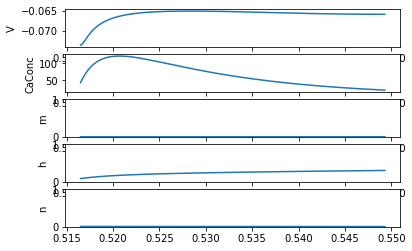

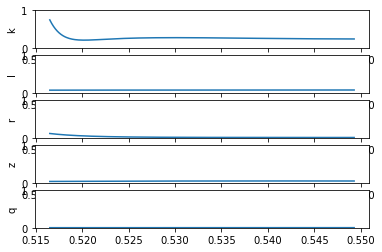


---------------------------------------------------------



ic| cell: 'C23'
ic| troughs: array([ 905, 2455])
ic| start: 2905, end: 4455


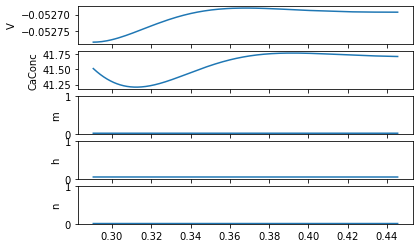

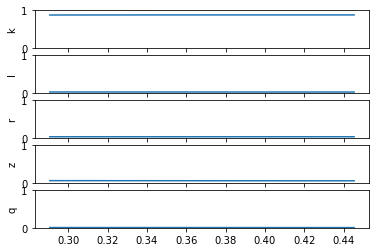


---------------------------------------------------------



ic| cell: 'C31'
ic| troughs: array([ 540, 2009, 3461, 4909, 6358, 7811])
ic| start: 5461, end: 6909


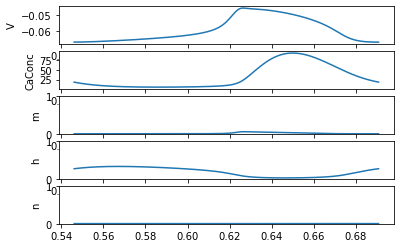

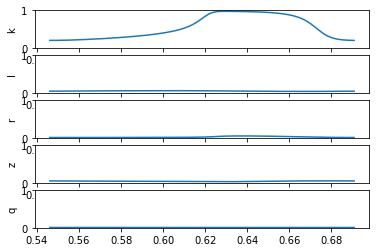


---------------------------------------------------------



ic| cell: 'C51B'
ic| troughs: array([ 718, 2107, 3406, 4661, 5895, 7120])
ic| start: 5406, end: 6661


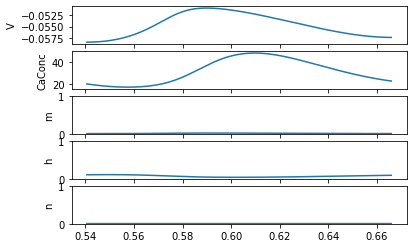

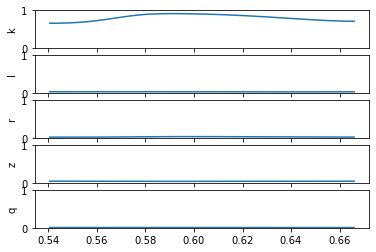


---------------------------------------------------------



In [82]:
cells = ['C11A','C23','C31','C51B']
#cells = ['C31']

for cell in cells:
    dend = 6 if cell == 'C10' or cell == 'C11A' else 5
    ic(cell)
    plt.subplot(5,1,1)
    volts = pd.DataFrame.transpose(pd.read_csv(f"{cell}_0_20to40_step0.1_v_nopulse.csv",index_col=0))['20.0degC']
    troughs,props = sg.find_peaks(-volts[2000:])
    ic(troughs)
    if len(troughs) < 2:
        print(f"Cell {cell}'s ass is NOT periodic!! He isn't even looking curvy!!")
        continue
    else:
        found = False
        for tt in troughs:
            if tt >= 3000 and found == False:
                nextstop = 15000
                for test in troughs:
                    if test - tt > 25 and test < nextstop:
                        nextstop = test
                if nextstop != 15000:
                    found = True
                    start = tt + 2000
                    end = nextstop + 2000
        if found != True:
            start = troughs[0] + 2000
            end = troughs[1] + 2000
            
    ic(start,end)
    plt.plot(t[start:end],volts[start:end])
    plt.ylabel('V')
    
    plt.subplot(5,1,2)
    yaxis = pd.DataFrame.transpose(pd.read_csv(f"{cell}_{dend}_20to40_step0.1_caConc_nopulse.csv",index_col=0))['20.0degC']
    plt.plot(t[start:end],yaxis[start:end])
    plt.ylabel('CaConc')
    
    plt.subplot(5,1,3)
    yaxis = pd.DataFrame.transpose(pd.read_csv(f"{cell}_0_20to40_step0.1_m_nopulse.csv",index_col=0))['20.0degC']
    plt.plot(t[start:end],yaxis[start:end])
    plt.ylim([0,1])
    plt.ylabel('m')
    
    plt.subplot(5,1,4)
    yaxis = pd.DataFrame.transpose(pd.read_csv(f"{cell}_0_20to40_step0.1_h_nopulse.csv",index_col=0))['20.0degC']
    plt.plot(t[start:end],yaxis[start:end])
    plt.ylim([0,1])
    plt.ylabel('h')
    
    plt.subplot(5,1,5)
    yaxis = pd.DataFrame.transpose(pd.read_csv(f"{cell}_0_20to40_step0.1_n_nopulse.csv",index_col=0))['20.0degC']
    plt.plot(t[start:end],yaxis[start:end])
    plt.ylim([0,1])
    plt.ylabel('n')
    plt.show()
    
    plt.subplot(5,1,1)
    yaxis = pd.DataFrame.transpose(pd.read_csv(f"{cell}_0_20to40_step0.1_k_nopulse.csv",index_col=0))['20.0degC']
    plt.plot(t[start:end],yaxis[start:end])
    plt.ylim([0,1])
    plt.ylabel('k')
    
    plt.subplot(5,1,2)
    yaxis = pd.DataFrame.transpose(pd.read_csv(f"{cell}_0_20to40_step0.1_l_nopulse.csv",index_col=0))['20.0degC']
    plt.plot(t[start:end],yaxis[start:end])
    plt.ylim([0,1])
    plt.ylabel('l')
    
    plt.subplot(5,1,3)
    yaxis = pd.DataFrame.transpose(pd.read_csv(f"{cell}_{dend}_20to40_step0.1_r_nopulse.csv",index_col=0))['20.0degC']
    plt.plot(t[start:end],yaxis[start:end])
    plt.ylim([0,1])
    plt.ylabel('r')
    
    plt.subplot(5,1,4)
    yaxis = pd.DataFrame.transpose(pd.read_csv(f"{cell}_{dend}_20to40_step0.1_z_nopulse.csv",index_col=0))['20.0degC']
    plt.plot(t[start:end],yaxis[start:end])
    plt.ylim([0,1])
    plt.ylabel('z')
    
    plt.subplot(5,1,5)
    yaxis = pd.DataFrame.transpose(pd.read_csv(f"{cell}_{dend}_20to40_step0.1_q_nopulse.csv",index_col=0))['20.0degC']
    plt.plot(t[start:end],yaxis[start:end])
    plt.ylim([0,1])
    plt.ylabel('q')
    plt.show()
    
    print("\n---------------------------------------------------------\n")

ic| cell: 'C31'
ic| troughs: array([ 540, 2009, 3461, 4909, 6358, 7811])
ic| start: 5461, end: 6909


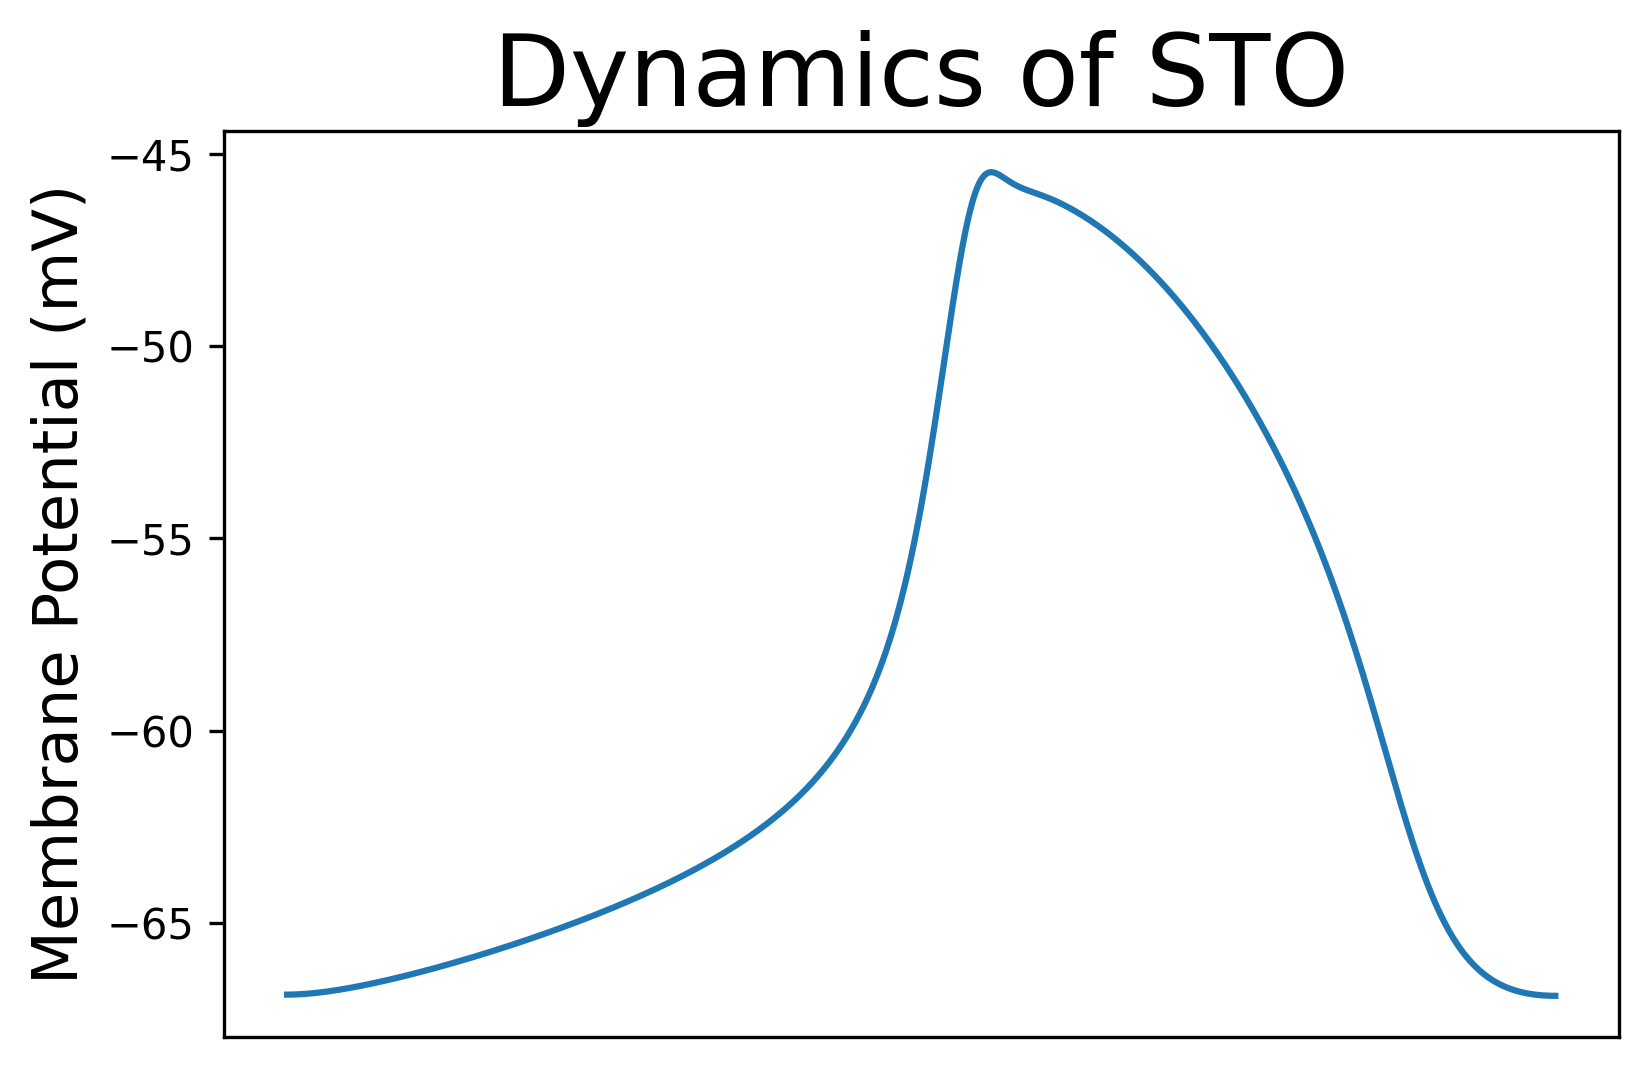

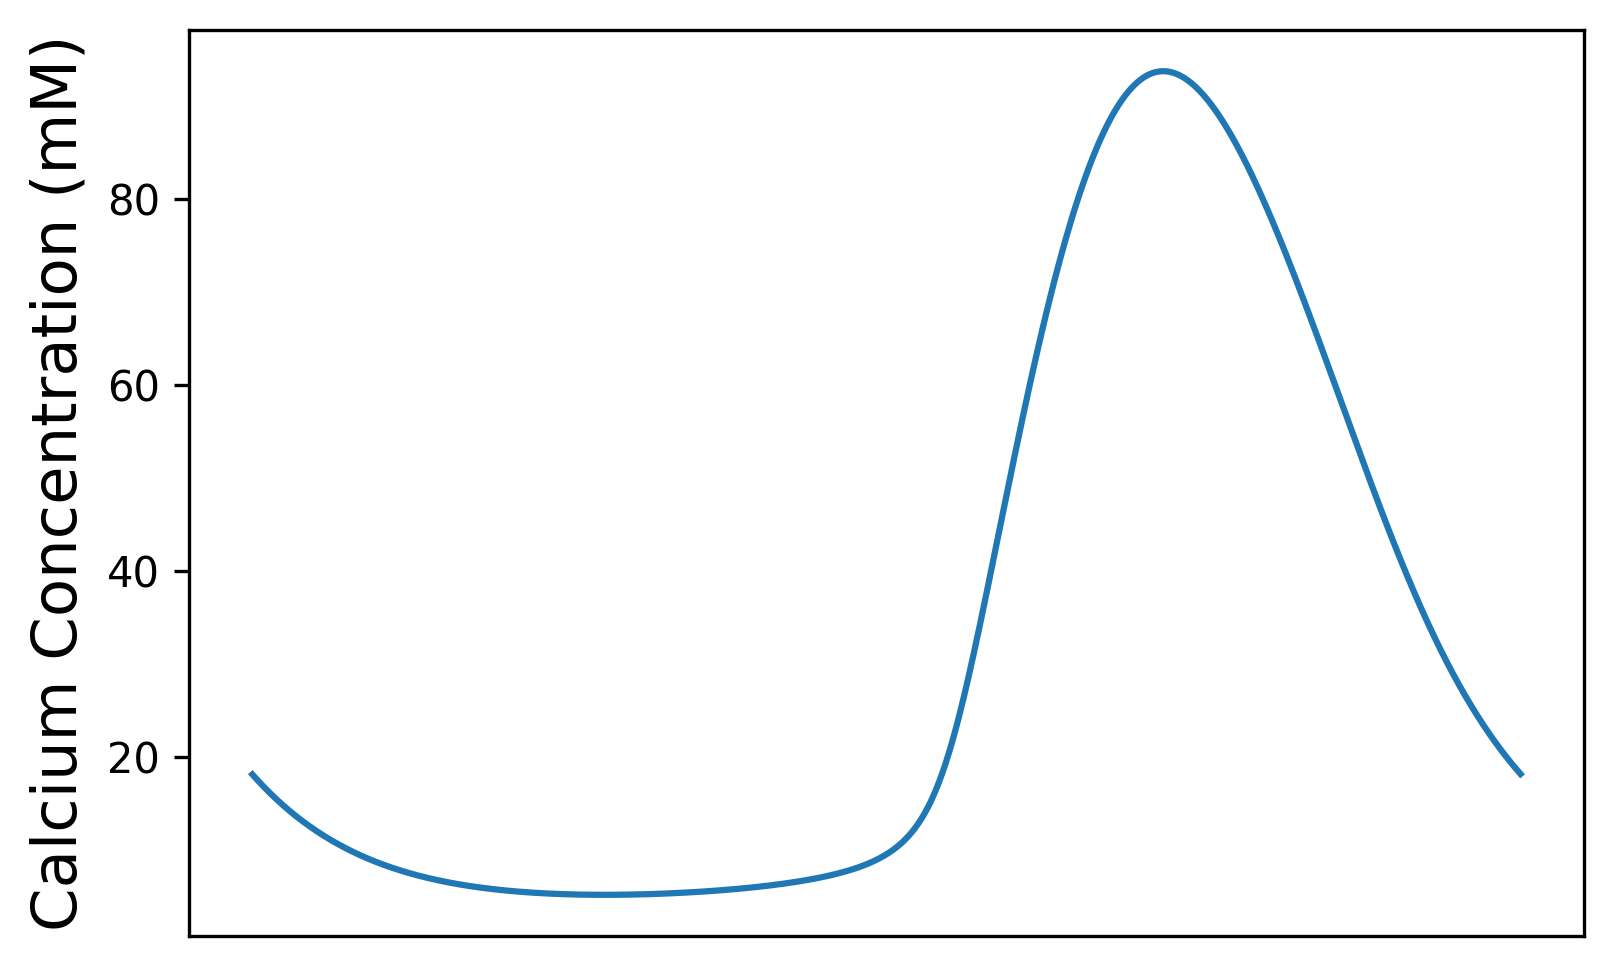

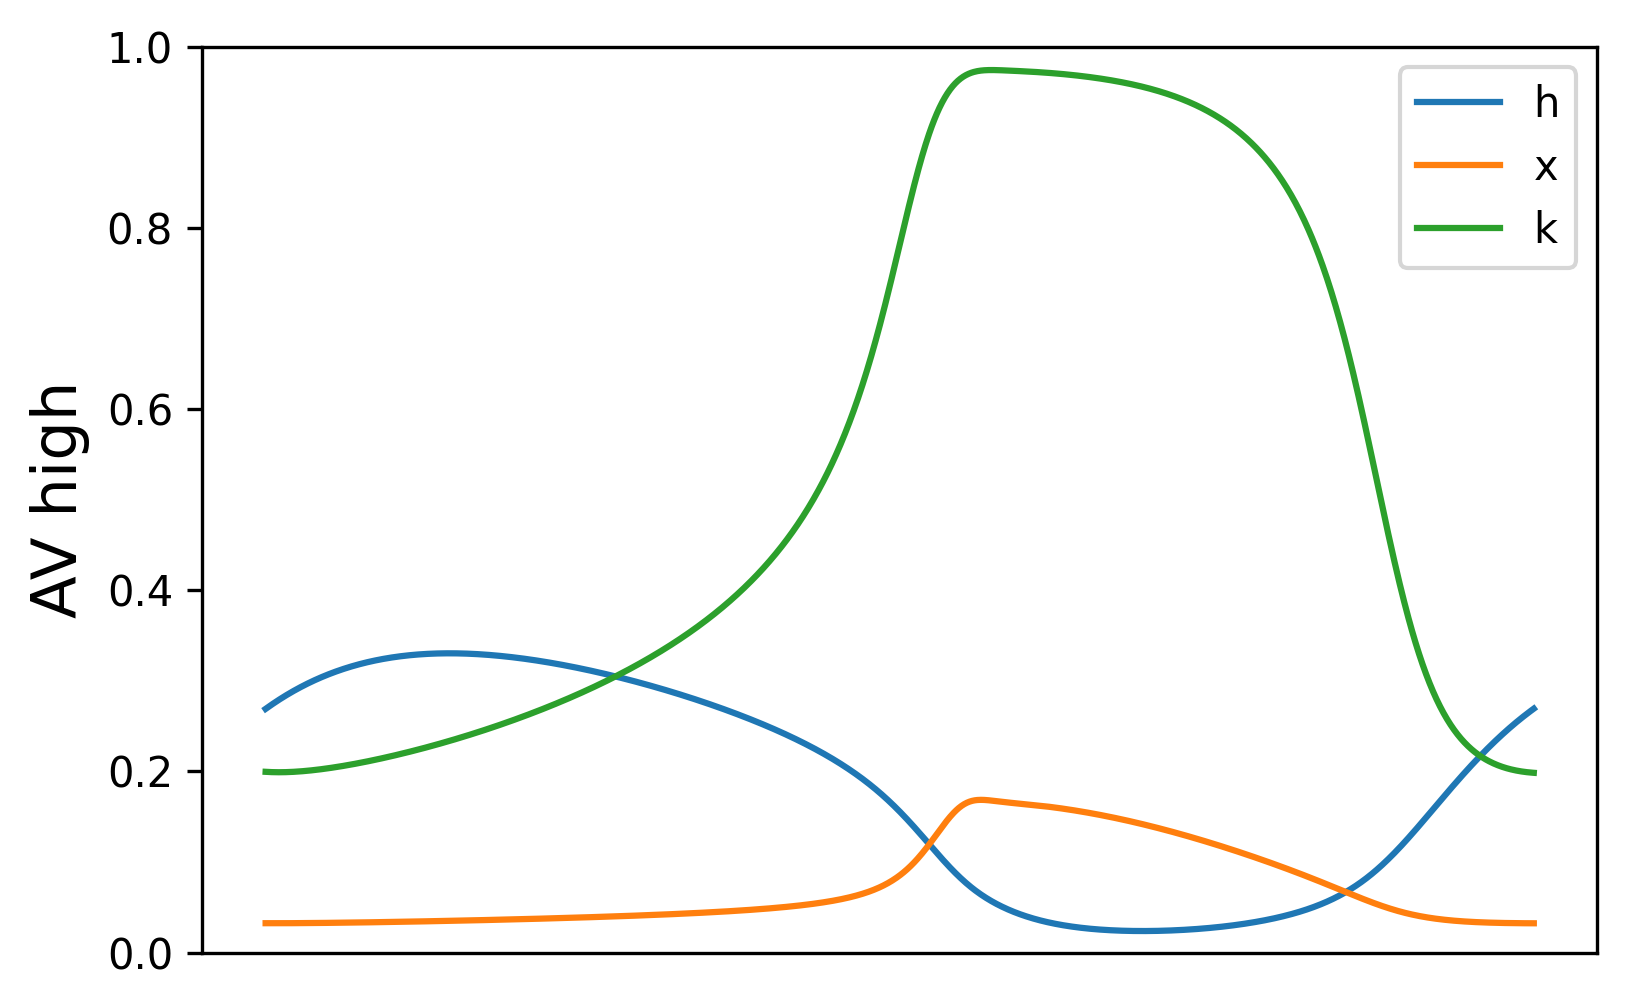

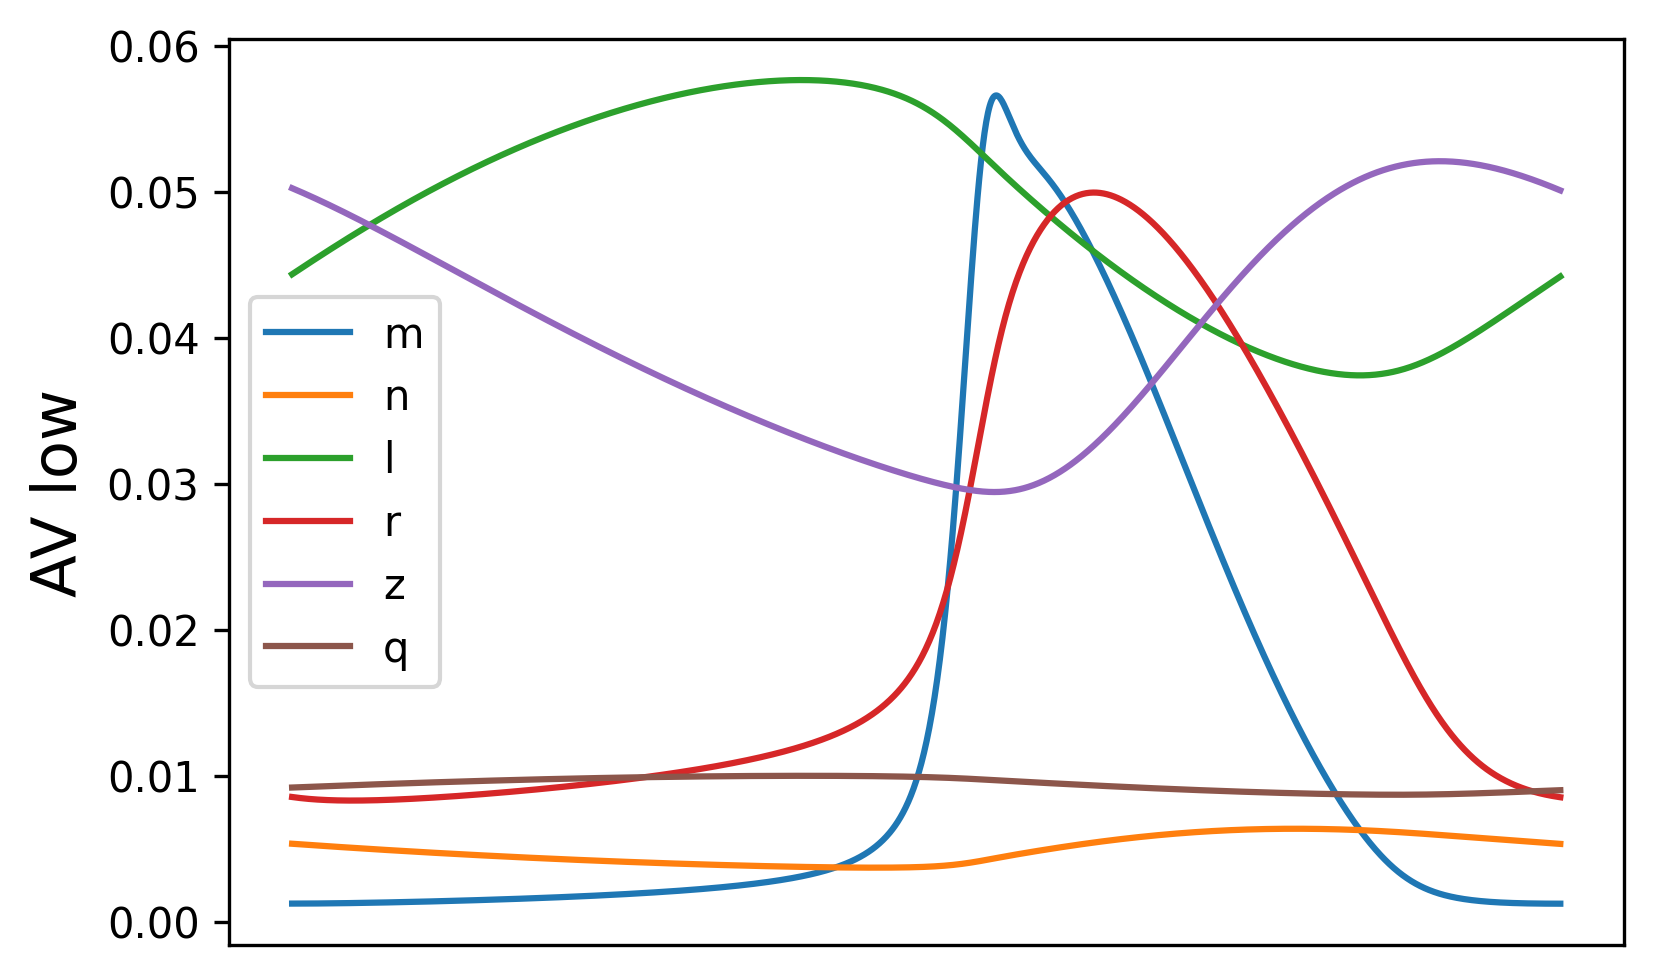


---------------------------------------------------------



In [18]:
cell = "C31"

dend = 6 if cell == 'C10' or cell == 'C11A' else 5
ic(cell)
volts = pd.DataFrame.transpose(pd.read_csv(f"{cell}_0_20to40_step0.1_v_nopulse.csv",index_col=0))['20.0degC']
troughs,props = sg.find_peaks(-volts[2000:])
ic(troughs)
if len(troughs) < 2:
    print(f"Cell {cell}'s ass is NOT periodic!! He isn't even looking curvy!!")
else:
    found = False
    for tt in troughs:
        if tt >= 3000 and found == False:
            nextstop = 15000
            for test in troughs:
                if test - tt > 25 and test < nextstop:
                    nextstop = test
            if nextstop != 15000:
                found = True
                start = tt + 2000
                end = nextstop + 2000
    if found != True:
        start = troughs[0] + 2000
        end = troughs[1] + 2000

ic(start,end)
fig = plt.figure()
ax = plt.axes()
ax.plot(t[start:end],volts[start:end]*1000)
fig.set_dpi(300.0)
ax.set_ylabel('Membrane Potential (mV)', fontsize = 15)
ax.set_title("Dynamics of STO", fontsize=24)
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

yaxis = pd.DataFrame.transpose(pd.read_csv(f"{cell}_{dend}_20to40_step0.1_caConc_nopulse.csv",index_col=0))['20.0degC']
fig = plt.figure()
ax = plt.axes()
ax.plot(t[start:end],yaxis[start:end])
fig.set_dpi(300.0)
ax.set_ylabel('Calcium Concentration (mM)', fontsize = 15)
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

yaxis = pd.DataFrame.transpose(pd.read_csv(f"{cell}_0_20to40_step0.1_h_nopulse.csv",index_col=0))['20.0degC']
fig = plt.figure()
ax = plt.axes()
ax.plot(t[start:end],yaxis[start:end])

yaxis = pd.DataFrame.transpose(pd.read_csv(f"{cell}_0_20to40_step0.1_x_nopulse.csv",index_col=0))['20.0degC']
ax.plot(t[start:end],yaxis[start:end])

yaxis = pd.DataFrame.transpose(pd.read_csv(f"{cell}_0_20to40_step0.1_k_nopulse.csv",index_col=0))['20.0degC']
ax.plot(t[start:end],yaxis[start:end])
fig.set_dpi(300.0)
ax.set_ylim([0,1])
ax.set_ylabel('AV high', fontsize = 15)
ax.legend(['h','x','k'])
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

yaxis = pd.DataFrame.transpose(pd.read_csv(f"{cell}_0_20to40_step0.1_m_nopulse.csv",index_col=0))['20.0degC']
fig = plt.figure()
ax = plt.axes()
ax.plot(t[start:end],yaxis[start:end])

#plt.hold(True)
yaxis = pd.DataFrame.transpose(pd.read_csv(f"{cell}_0_20to40_step0.1_n_nopulse.csv",index_col=0))['20.0degC']
ax.plot(t[start:end],yaxis[start:end])

#plt.hold(True)
yaxis = pd.DataFrame.transpose(pd.read_csv(f"{cell}_0_20to40_step0.1_l_nopulse.csv",index_col=0))['20.0degC']
ax.plot(t[start:end],yaxis[start:end])

#plt.hold(True)
yaxis = pd.DataFrame.transpose(pd.read_csv(f"{cell}_{dend}_20to40_step0.1_r_nopulse.csv",index_col=0))['20.0degC']
ax.plot(t[start:end],yaxis[start:end])

#plt.hold(True)
yaxis = pd.DataFrame.transpose(pd.read_csv(f"{cell}_{dend}_20to40_step0.1_z_nopulse.csv",index_col=0))['20.0degC']
ax.plot(t[start:end],yaxis[start:end])

#plt.hold(True)
yaxis = pd.DataFrame.transpose(pd.read_csv(f"{cell}_{dend}_20to40_step0.1_q_nopulse.csv",index_col=0))['20.0degC']
ax.plot(t[start:end],yaxis[start:end])
fig.set_dpi(300.0)
#ax.ylim([0,0.2])
ax.set_ylabel('AV low', fontsize = 15)
ax.legend(['m','n','l','r','z','q'])
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

print("\n---------------------------------------------------------\n")

### Channel Behaviour

The behaviour of gates, and thus of channels, is determined by a set of forward and reverse rates between the gates' open and closed states. These rates, commonly defined as α and β, are dependent on the membrane potential. When combined, these two rates define a steady-state gating variable and a time constant variable, both dependent on the membrane potential. These two variables give a big insight as to how the channel might behave.

ic| m_inf: array([2.96902870e-06, 3.02350461e-06, 3.07898005e-06, ...,
                  9.99999491e-01, 9.99999500e-01, 9.99999509e-01])


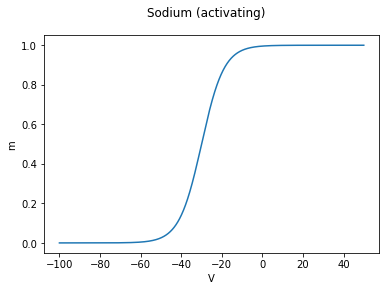

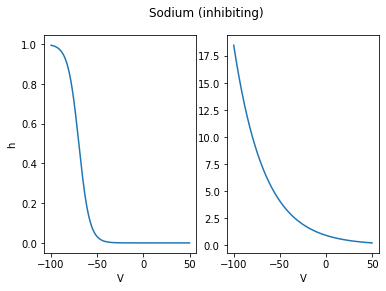

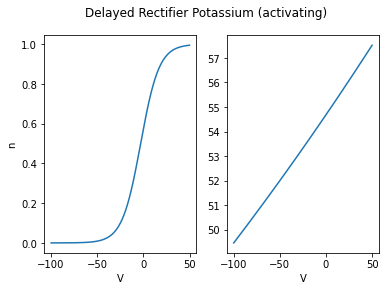

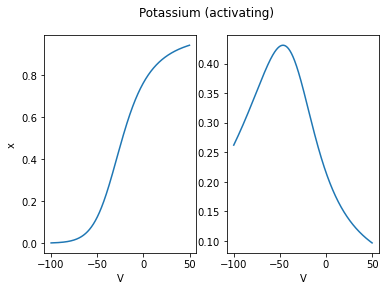

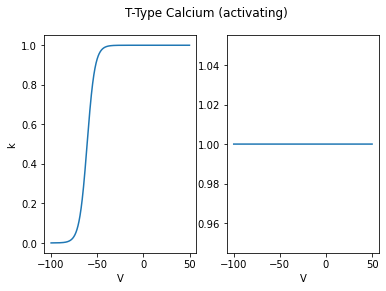

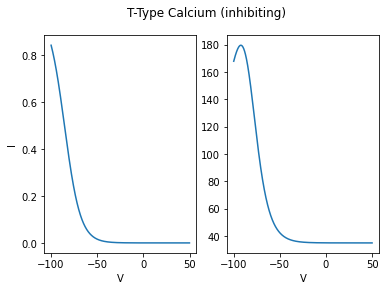

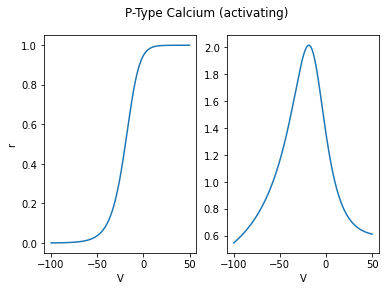

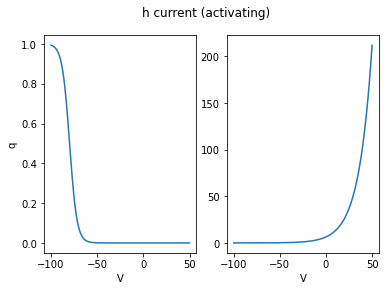

In [106]:
V = np.arange(-100,50,0.1)

m_inf = 1 / (1 + np.exp((-30 - V)/5.5))
ic(m_inf)
plt.plot(V,m_inf)
plt.xlabel('V')
plt.ylabel('m')
plt.suptitle('Sodium (activating)')
plt.show()

plt.subplot(1,2,1)
h_inf = 1 / (1 + np.exp(-(-70 - V)/5.8))
plt.plot(V,h_inf)
plt.xlabel('V')
plt.ylabel('h')
plt.subplot(1,2,2)
tau_h = 3*np.exp((-40 - V)/33)
plt.plot(V,tau_h)
plt.xlabel('V')
plt.suptitle('Sodium (inhibiting)')
plt.show()

plt.subplot(1,2,1)
n_inf = 1 / (1 + np.exp((-3 - V)/10))
plt.plot(V,n_inf)
plt.xlabel('V')
plt.ylabel('n')
plt.subplot(1,2,2)
tau_n = 5 + 47*np.exp(-(-50 - V)/900)
plt.plot(V,tau_n)
plt.xlabel('V')
plt.suptitle('Delayed Rectifier Potassium (activating)')
plt.show()

plt.subplot(1,2,1)
alpha_x = (0.13*(V + 25))/(1 - np.exp((-25 - V)/10))
beta_x = 1.69 * np.exp((-35 - V)/80)
x_inf = alpha_x / (alpha_x + beta_x)
plt.plot(V,x_inf)
plt.xlabel('V')
plt.ylabel('x')
plt.subplot(1,2,2)
tau_x = 1 / (alpha_x + beta_x)
plt.plot(V,tau_x)
plt.xlabel('V')
plt.suptitle('Potassium (activating)')
plt.show()

plt.subplot(1,2,1)
k_inf = 1 / (1 + np.exp((-61 - V)/4.2))
plt.plot(V,k_inf)
plt.xlabel('V')
plt.ylabel('k')
plt.subplot(1,2,2)
tau_k = [1 for vv in V]
plt.plot(V,tau_k)
plt.xlabel('V')
plt.suptitle('T-Type Calcium (activating)')
plt.show()

plt.subplot(1,2,1)
l_inf = 1 / (1 + np.exp(-(-85.5 - V)/8.6))
plt.plot(V,l_inf)
plt.xlabel('V')
plt.ylabel('l')
plt.subplot(1,2,2)
tau_l = 35 + (20*np.exp(-(-160 - V)/30))/(1 + np.exp(-(-84 - V)/(7.3)))
plt.plot(V,tau_l)
plt.xlabel('V')
plt.suptitle('T-Type Calcium (inhibiting)')
plt.show()

plt.subplot(1,2,1)
alpha_r = 1.7 / (1 + np.exp(-(V - 5)/13.9))
beta_r = (0.02*(V + 8.5)) / (np.exp(-(-8.5 - V)/5) - 1)
r_inf = alpha_r / (alpha_r + beta_r)
plt.plot(V,r_inf)
plt.xlabel('V')
plt.ylabel('r')
plt.subplot(1,2,2)
tau_r = 1 / (alpha_r + beta_r)
plt.plot(V,tau_r)
plt.xlabel('V')
plt.suptitle('P-Type Calcium (activating)')
plt.show()

plt.subplot(1,2,1)
q_inf = 1 / (1 + np.exp(-(-80 - V)/4))
plt.plot(V,q_inf)
plt.xlabel('V')
plt.ylabel('q')
plt.subplot(1,2,2)
tau_q = 1 / (np.exp((-169.8 - V)/11.6) + np.exp((-26.7 - V)/14.3))
plt.plot(V,tau_q)
plt.xlabel('V')
plt.suptitle('h current (activating)')
plt.show()

### Q10 Behaviour

The regular HH model does in itself not account for changes in temperature. To do this, we make use of a common biological scaling coëfficient, known as the Q10 factor. How does this Q10 factor change a certain parameter over a change in temperature?

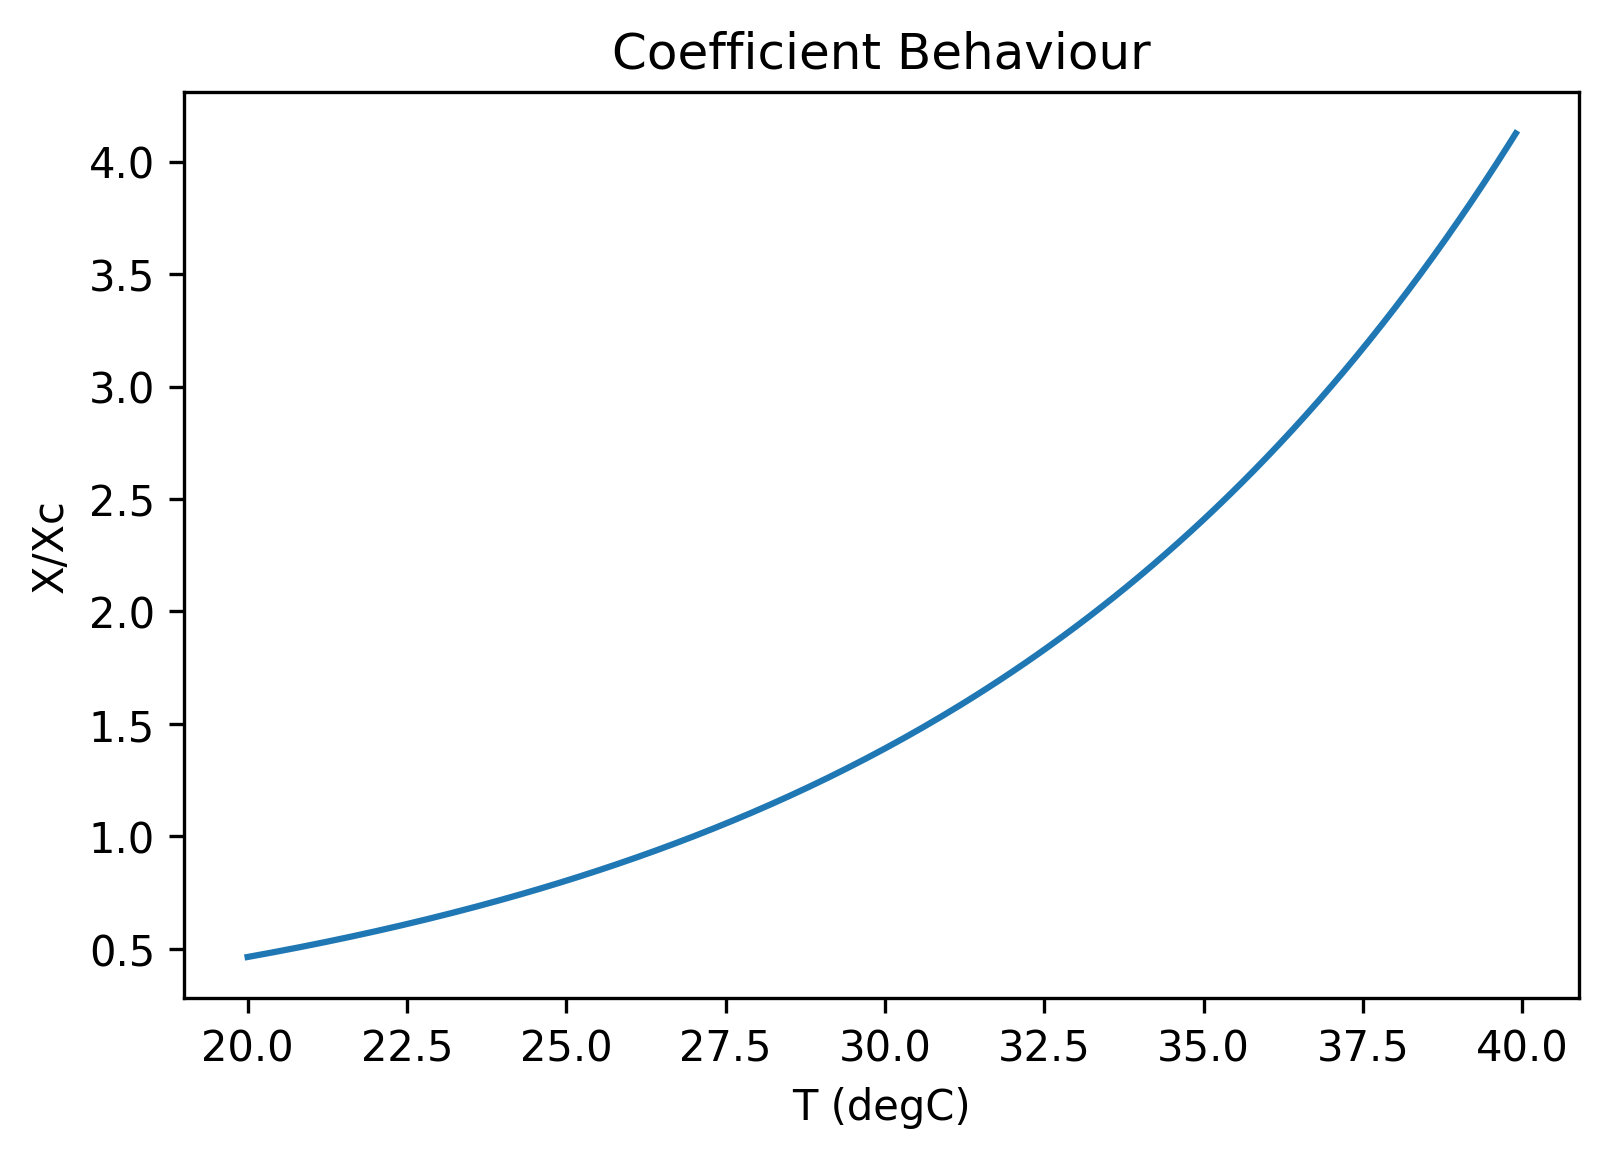

In [19]:
T = np.arange(20,40,0.1)

Qten = 3
Tc = 27

phi = Qten**((T - Tc)/10)

fig = plt.figure()
ax = plt.axes()
ax.plot(T,phi)
fig.set_dpi(300.0)
ax.set_xlabel('T (degC)')
ax.set_ylabel('X/Xc')
ax.set_title('Coefficient Behaviour')
plt.show()

Since the steady state value of the activation variables is defined as a rate over a sum of rates, in other words it is dimensionless, the temperature coefficient will not have any effect on it. It will however influence the time constants.

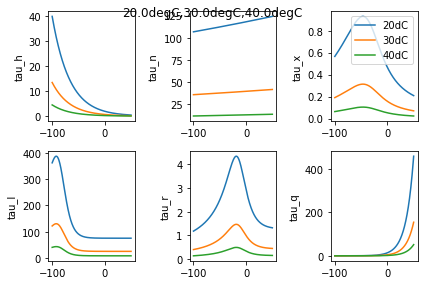

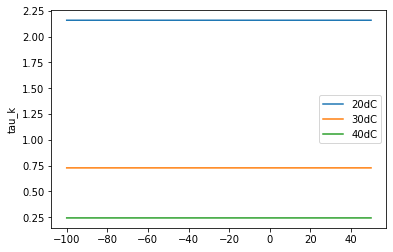

In [121]:
plt.subplot(231)
plt.plot(V,tau_h/phi[0])
plt.plot(V,tau_h/phi[99])
plt.plot(V,tau_h/phi[-1])
plt.ylabel('tau_h')
plt.subplot(232)
plt.plot(V,tau_n/phi[0])
plt.plot(V,tau_n/phi[99])
plt.plot(V,tau_n/phi[-1])
plt.ylabel('tau_n')
plt.subplot(233)
plt.plot(V,tau_x/phi[0])
plt.plot(V,tau_x/phi[99])
plt.plot(V,tau_x/phi[-1])
plt.ylabel('tau_x')
plt.legend(['20dC','30dC','40dC'])
plt.subplot(234)
plt.plot(V,tau_l/phi[0])
plt.plot(V,tau_l/phi[99])
plt.plot(V,tau_l/phi[-1])
plt.ylabel('tau_l')
plt.subplot(235)
plt.plot(V,tau_r/phi[0])
plt.plot(V,tau_r/phi[99])
plt.plot(V,tau_r/phi[-1])
plt.ylabel('tau_r')
plt.subplot(236)
plt.plot(V,tau_q/phi[0])
plt.plot(V,tau_q/phi[99])
plt.plot(V,tau_q/phi[-1])
plt.ylabel('tau_q')
plt.suptitle('20.0degC,30.0degC,40.0degC')
plt.tight_layout()
plt.show()




plt.plot(V,tau_k/phi[0])
plt.plot(V,tau_k/phi[99])
plt.plot(V,tau_k/phi[-1])
plt.ylabel('tau_k')
plt.legend(['20dC','30dC','40dC'])
plt.show()

### Clusters of Interest

Some cells turn out to have a very peculiar and sudden change of behaviour when the temperature changes. Known as bifurcations, these changes occur in very specific temperature regions. What is the region when that change occurs, and whih type of bifurcation are we dealing with?

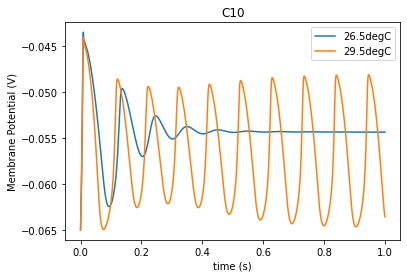

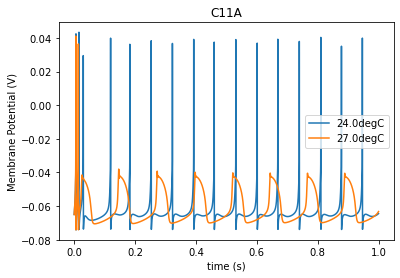

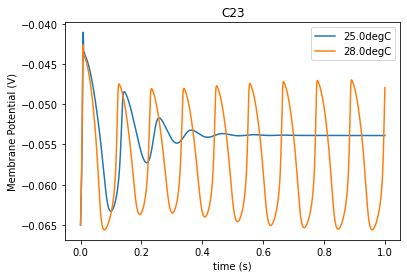

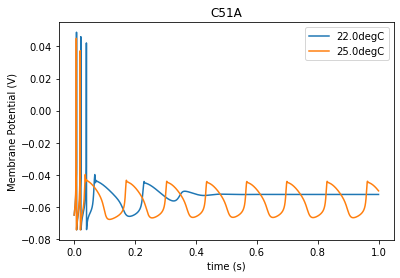

In [103]:
'''

Clusters of interest:
 -> C10  26.5-29.5
 -> C11A 24.0-27.0
 -> C23  25.0-28.0
 -> C51A 22.0-25.0

'''

traces_10 = pd.DataFrame.transpose(pd.read_csv(f"C10_0_20to40_step0.1_v_nopulse.csv",index_col=0))
traces_11A = pd.DataFrame.transpose(pd.read_csv(f"C11A_0_20to40_step0.1_v_nopulse.csv",index_col=0))
traces_23 = pd.DataFrame.transpose(pd.read_csv(f"C23_0_20to40_step0.1_v_nopulse.csv",index_col=0))
traces_51A = pd.DataFrame.transpose(pd.read_csv(f"C51A_0_20to40_step0.1_v_nopulse.csv",index_col=0))

plt.plot(t,traces_10['26.5degC'])
plt.plot(t,traces_10['29.5degC'])
plt.xlabel('time (s)')
plt.ylabel('Membrane Potential (V)')
plt.legend(['26.5degC','29.5degC'])
plt.title('C10')
plt.show()

plt.plot(t,traces_11A['24.0degC'])
plt.plot(t,traces_11A['27.0degC'])
plt.xlabel('time (s)')
plt.ylabel('Membrane Potential (V)')
plt.legend(['24.0degC','27.0degC'])
plt.title('C11A')
plt.show()

plt.plot(t,traces_23['25.0degC'])
plt.plot(t,traces_23['28.0degC'])
plt.xlabel('time (s)')
plt.ylabel('Membrane Potential (V)')
plt.legend(['25.0degC','28.0degC'])
plt.title('C23')
plt.show()

plt.plot(t,traces_51A['22.0degC'])
plt.plot(t,traces_51A['25.0degC'])
plt.xlabel('time (s)')
plt.ylabel('Membrane Potential (V)')
plt.legend(['22.0degC','25.0degC'])
plt.title('C51A')
plt.show()

### Cellular Behaviour

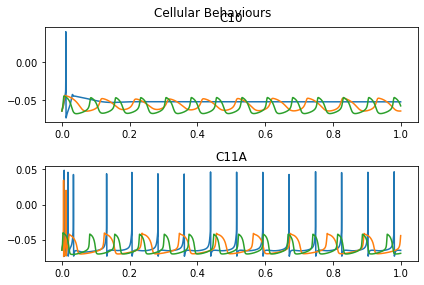

In [137]:
%matplotlib inline
cells = ['C10','C11A']

plt.subplot()
for cellnum in range(0,len(cells)):
    y = pd.DataFrame.transpose(pd.read_csv(f"{cells[cellnum]}_0_20to40_step10_v_nopulse.csv",index_col=0))
    t = np.linspace(0,1,10001)
    plt.subplot(2,1,cellnum+1)
    plt.plot(t,y['20degC'])
    plt.plot(t,y['30degC'])
    plt.plot(t,y['40degC'])
    #plt.xlabel('Time (s)')
    #plt.ylabel('Voltage (V)')
    plt.title(cells[cellnum])
plt.suptitle('Cellular Behaviours')
plt.tight_layout()
plt.show()